# Example 1: Interactive Map and Network Color Diagram

# PT3S Release

In [1]:
#pip install PT3S -U --no-deps

# Necessary packages for this Example

In [2]:
pip -q install Pillow selenium

Note: you may need to restart the kernel to use updated packages.


# Imports

In [3]:
import os
import geopandas
import logging
import pandas as pd
import io
import subprocess
import matplotlib.pyplot as plt
import contextily as cx

from PIL import Image

import folium
from folium.plugins import HeatMap

try:
    from PT3S import dxAndMxHelperFcts
except:
    import dxAndMxHelperFcts

try:
    from PT3S import ncd
except:
    import ncd

try:
    from PT3S import Rm
except:
    import Rm

In [4]:
import importlib

In [5]:
importlib.reload(dxAndMxHelperFcts)

<module 'dxAndMxHelperFcts' from 'c:\\users\\jablonski\\3s\\pt3s\\dxAndMxHelperFcts.py'>

# Logging

In [6]:
logger = logging.getLogger()  

logFileName= r"Example1.log" 

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")    

fileHandler = logging.FileHandler(logFileName)     

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# Read Model and Results

In [7]:
dbFilename="Example1"
dbFile=os.path.join(os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))
                    +'/Examples/'
                    +dbFilename
                    +'.db3'
)

In [8]:
m=dxAndMxHelperFcts.readDxAndMx(dbFile=dbFile                                 
                                ,preventPklDump=True
                                ,maxRecords=-1
)

INFO    ; Dx.__init__: dbFile (abspath): c:\users\aUserName\3s\pt3s\Examples\Example1.db3 exists readable ...
INFO    ; dxAndMxHelperFcts.readDxAndMx: 
+..\Examples\Example1.db3 is newer than
+..\Examples\WDExample1\B1\V0\BZ1\M-1-0-1.1.MX1:
+SIR 3S' dbFile is newer than SIR 3S' mx1File
+in this case the results are maybe dated or (worse) incompatible to the model
INFO    ; dxAndMxHelperFcts.readDxAndMx: running C:\\3S\SIR 3S Entwicklung\SirCalc-90-15-00-12_Quebec.alpha_x64\SirCalc.exe ...
INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample1\B1\V0\BZ1\M-1-0-1.1.MXS reading ...
INFO    ; dxWithMx.__init__: Example1: processing dx and mx ...


# Interactive Map with folium/leaflet.js

## gdfs

In [9]:
gdf_ROHR = m.gdf_ROHR.dropna(subset=['geometry'])
gdf_FWVB = m.gdf_FWVB.dropna(subset=['geometry'])

## filter layer

In [10]:
xk='pk'

In [11]:
gdf_ROHR=gdf_ROHR[gdf_ROHR[xk].isin(
    m.dx.dfLAYR[m.dx.dfLAYR['NAME'].isin(['Optimierungsgebiet'])]['ID']
)]

In [12]:
gdf_FWVB=gdf_FWVB[gdf_FWVB[xk].isin(
    m.dx.dfLAYR[m.dx.dfLAYR['NAME'].isin(['FWVB GebMitte'])]['ID']
)]

## heatmap

In [13]:
# Convert gdf_FWVB to EPSG:4326 CRS and get coordinates
dfData = gdf_FWVB.to_crs('EPSG:4326').geometry.get_coordinates()

In [14]:
dfData['W'] = gdf_FWVB['W']

In [15]:
# Prepare data for heatmap
heatMapDataW = [[row['y'], row['x'], row['W']] for index, row in dfData.iterrows()]

In [16]:
heatMapDataW[0]

[50.32412995810416, 11.999335341082608, 33.838565826416016]

In [17]:
x_mean = dfData['x'].mean()
y_mean = dfData['y'].mean()

## parameter

In [18]:
minRadius = 2
maxRadius = 10 * minRadius
facRadius = 1 / 10.
minWidthinPixel = 1
maxWidthinPixel = 3 * minWidthinPixel
facWidthinPixel1DN = 1 / 200
facWidthinPixelQMAVAbs = 1 / 10

## build the map

In [19]:
# Create a folium Map
map = folium.Map(location=(y_mean, x_mean), titles='CartoDB Positron', zoom_start=16)

# Add 'W' layer to the map
gdf_FWVB.loc[:, ['geometry', 'W']].explore(
    column='W',
    cmap='autumn_r',
    legend=False,
    vmin=gdf_FWVB['W'].quantile(.025),
    vmax=gdf_FWVB['W'].quantile(.975),
    style_kwds={'style_function': lambda x: {'radius': min(max(x['properties']['W'] * facRadius, minRadius), maxRadius)}},
    name='W',
    show=False,
    m=map
)

# Add 'W' HeatMap layer to the map
HeatMap(heatMapDataW, name='Heat Map von W', radius=10, blur=5, base=True).add_to(map)

# Add 'DI' layer to the map
gdf_ROHR[(gdf_ROHR['KVR'].isin([1., None])) & (gdf_ROHR['DI'] != 994)].loc[:, ['geometry', 'DI']].explore(
    column='DI',
    cmap='gray',
    legend=True,
    vmin = gdf_ROHR.loc[gdf_ROHR['DI'] != 994, 'DI'].quantile(.2),
    vmax = 1.5 * gdf_ROHR.loc[gdf_ROHR['DI'] != 994, 'DI'].quantile(1),
    style_kwds={'style_function': lambda x: {'radius': min(max(x['properties']['DI'] * facWidthinPixel1DN, minWidthinPixel), maxWidthinPixel)}},
    name='DI',
    m=map
)

# Add 'QMAVAbs' layer to the map
gdf_ROHR[gdf_ROHR['KVR'].isin([1., None])].loc[:, ['geometry', 'QMAVAbs']].explore(
    column='QMAVAbs',
    cmap='cool',
    legend=True, 
    vmin=gdf_ROHR['QMAVAbs'].quantile(.2),
    vmax=gdf_ROHR['QMAVAbs'].quantile(.80),
    style_kwds={'style_function': lambda x: {'weight': min(max(x['properties']['QMAVAbs'] * facWidthinPixelQMAVAbs, minWidthinPixel), maxWidthinPixel)}},
    name='QMAVAbs',
    m=map
)

# Add LayerControl to the map
folium.LayerControl().add_to(map)

## display the map

In [20]:
map
#NBVAL_IGNORE_OUTPUT

## print the map

In [21]:
img_data = map._to_png(5)
img = Image.open(io.BytesIO(img_data))

In [22]:
img.save('Example1_Output.png')

In [23]:
img.save('Example1_Output.pdf')

# Network Color Diagram with matplotlib

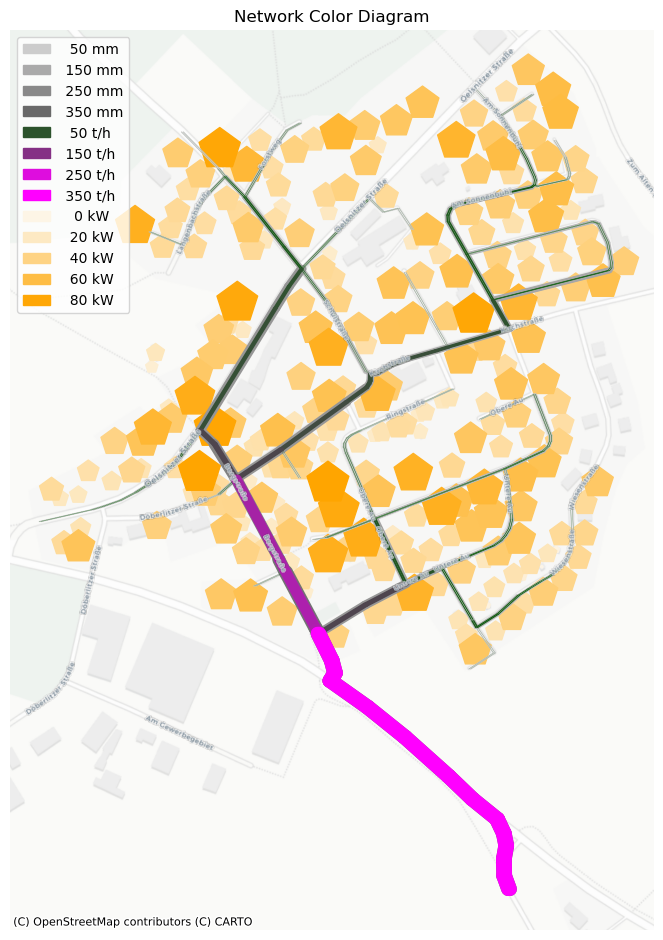

In [24]:
fig, ax = plt.subplots(figsize=Rm.DINA3q)

nodes_patches_1 = ncd.pNcd_nodes(ax=ax,
                                 gdf=gdf_FWVB,
                                 attribute='W',  # kW
                                 colors=['oldlace', 'orange'],
                                 marker_style='p',
                                 legend_fmt='{:4.0f} kW',
                                 legend_values=[0, 20, 40, 60, 80],
                                 zorder=1)

pipes_patches_2 = ncd.pNcd_pipes(ax=ax,
                                 gdf=gdf_ROHR,
                                 attribute='DI',
                                 colors=['lightgray', 'dimgray'],
                                 legend_fmt='{:4.0f} mm',
                                 legend_values=[50, 150, 250, 350],
                                 zorder=2)

pipes_patches_3 = ncd.pNcd_pipes(ax=ax,
                                 gdf=gdf_ROHR,
                                 attribute='QMAVAbs',
                                 colors=['darkgreen', 'magenta'],
                                 legend_fmt='{:4.0f} t/h',
                                 legend_values=[50, 150, 250, 350],
                                 zorder=3)

all_patches = pipes_patches_2 + pipes_patches_3 + nodes_patches_1
ax.legend(handles=all_patches, loc='best')

cx.add_basemap(ax, crs=gdf_ROHR.crs.to_string(), source=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax, crs=gdf_ROHR.crs.to_string(), source=cx.providers.CartoDB.PositronOnlyLabels)

plt.title('Network Color Diagram')

plt.savefig('Example1_Output_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
m.V3_ROHR.head()

,pk,fkDE,rk,tk,fkKI,fkKK,fkDTRO_ROWD,fkLTGR,fkSTRASSE,L,...,"('TMIN', 'KNOT~*~*~*~T', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-13 23:00:00'))_k","('TMAX', 'KNOT~*~*~*~T', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-13 23:00:00'))_k","('STAT', 'KNOT~*~*~*~RHO', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-12 23:00:00'))_k","('TIME', 'KNOT~*~*~*~RHO', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-12 23:00:00'))_k","('TMIN', 'KNOT~*~*~*~RHO', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-13 23:00:00'))_k","('TMAX', 'KNOT~*~*~*~RHO', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-13 23:00:00'))_k",QMAVAbs,VAVAbs,PHRAbs,JVAbs
0,5442010239090746007,5306805303452857793,5442010239090746007,5442010239090746007,5669301360686511351,5397948523091900401,4684070986837856878,4779752876656844188,5644881417512616095,36.429348,...,89.710632,89.852081,965.873596,965.873596,965.788757,965.873596,52.848248,0.753102,0.010421,0.286070
1,4917786378639043296,5306805303452857793,4917786378639043296,4917786378639043296,5397948523091900401,5239335112004772156,5103141232976878720,4779752876656844188,5644881417512616095,57.217808,...,89.515228,89.751282,965.990845,965.990845,965.849243,965.990845,29.673883,0.626446,0.014625,0.255595
2,4762482310382009633,5306805303452857793,4762482310382009633,4762482310382009633,5239335112004772156,5298886695042021307,5103141232976878720,4779752876656844188,5644881417512616095,40.994816,...,89.480621,89.733521,966.011597,966.011597,965.859863,966.011597,30.252331,0.638583,0.010872,0.265203
3,4987229536643024523,5306805303452857793,4987229536643024523,4987229536643024523,5298886695042021307,4993257270457791438,5103141232976878720,4779752876656844188,5644881417512616095,6.833079,...,89.474854,89.73056,966.015076,966.015076,965.861694,966.015076,30.252331,0.638575,0.001812,0.265205
4,5722206630503885118,5306805303452857793,5722206630503885118,5722206630503885118,4993257270457791438,5317865645994989592,5103141232976878720,4779752876656844188,5644881417512616095,7.493101,...,89.468536,89.727295,966.01886,966.01886,965.863647,966.01886,30.252331,0.638572,0.001987,0.265206
